<a href="https://colab.research.google.com/github/gelgel5633/exploration/blob/main/%5BGoing_Deeper_6%5Dbias_test_from_all_genres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install konlpy

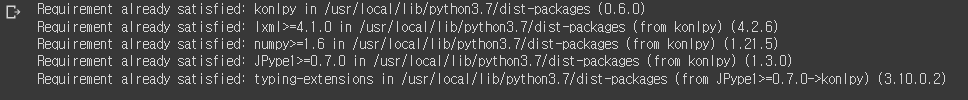

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from konlpy.tag import Okt
import os
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

plt.rc('font', family='NanumBarunGothic') 

In [ ]:
#코사인 유사도 구하는 함수
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

#weat_score의 분자를 구하는 함수
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

#weat_score 구하는 함수
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

# 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [ ]:
okt = Okt()
tokenized = []
#synopsis.txt에는 2001년~2019년 8월까지 영화의 시놉시스 존재
with open('/content/drive/MyDrive/test/data/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        #okt.pos를 통해 품사를 태딩하고 아래 for문에 적용
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # 품사가 명사일 떄
                res.append(w[0])    # tokenized 에 저장한다.
        tokenized.append(res)

print(len(tokenized))

image.png

# 추출된 결과로 embedding model 만들기

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(tokenized, size=300, window=5, min_count=3, sg=0)
#테스트 결과
#매개변수 topn을 5로 설정하고 상위 5개 항목만 출력
print(model.most_similar(positive=['공포'], topn=5))
print("-------------------------------------------------------")
print(model.most_similar(positive=['스릴'], topn=5))

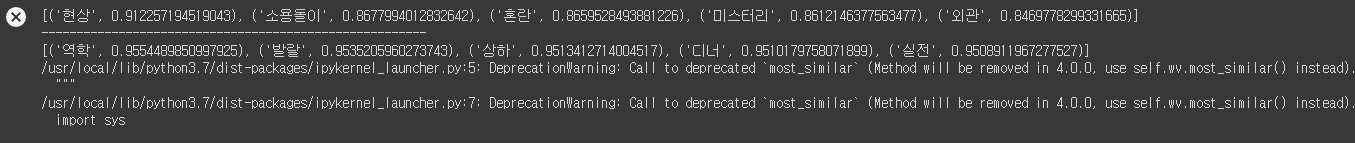

size를 100으로 하였을 때는 스릴 항목에서 등장인물의 이름이 다수 나왔었는데, 사이즈를 키움으로써 이를 해소할 수 있었다.

# target, attribute 단어 셋 만들기

target, attribute는 각각 weat score를 구하기 위하여 만들어 주어야 한다. 

In [ ]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open('/content/drive/MyDrive/test/data/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽는 중')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [ ]:
#art와 gen는 예술영화와 상업영화의 장르를 가르는 target
art = read_token(art_txt)
gen = read_token(gen_txt)

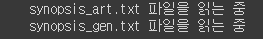

In [ ]:
#오류 방지를 위한 복사본 생성
art_copy = art
gen_copy = gen

In [ ]:
#tfidf vectorizer를 사용하여 단어셋 구성
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art_copy, gen_copy])

In [ ]:
#coo 행렬로 변환
m1 = X[0].tocoo() # art를 TF-IDF로 표현한 sparse matrix
m2 = X[1].tocoo() # gen을 TF-IDF로 표현한 sparse matrix

#중복제거를 위해 1열과 2열에서 0의 값을 삭제
m1.eliminate_zeros()
m2.eliminate_zeros()

In [ ]:
w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(40):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(40):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

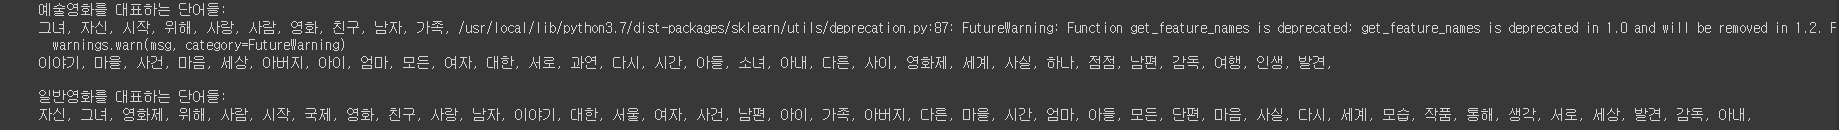

In [ ]:
n = 20
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 n개 추출
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 n개 추출
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

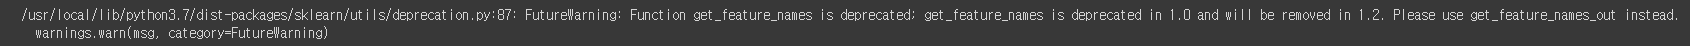

In [ ]:
print(target_art)
print(target_gen)

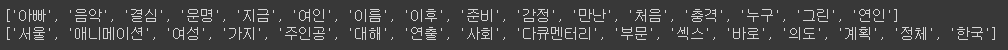

In [ ]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [ ]:
#genre = attribute 역할을 함. weat_score에서 
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

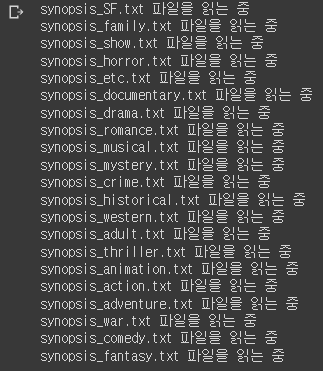

In [ ]:
len(genre)

image.png

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

image.png

In [ ]:
# 각 장르 대표단어 추출
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

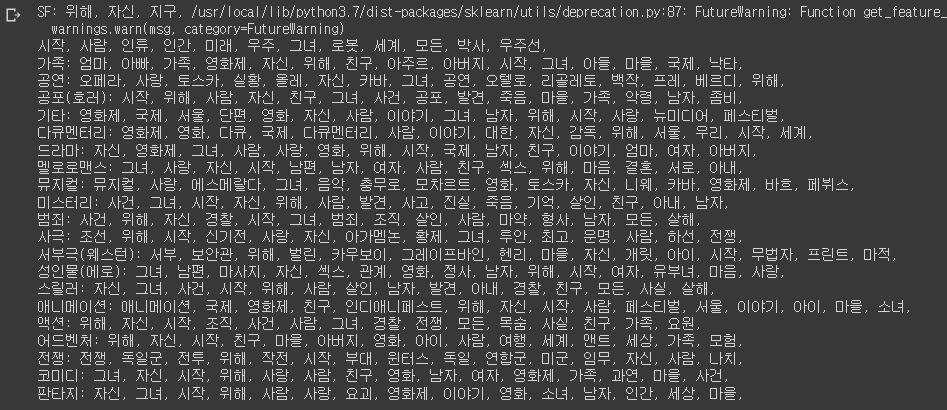

# WEAT score 계산과 시각화

In [ ]:
#embedding model과 단어셋으로 weat score 구하기
#구한 결과를 21*21 매트릭스형태로 표현
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [ ]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [ ]:
#weat score 값 확인
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        #절대값이 0.9이상인 것들만 출력
        if abs(matrix[i][j]) >= 0.9:
            print(genre_name[i], genre_name[j],matrix[i][j])
        else:
            continue

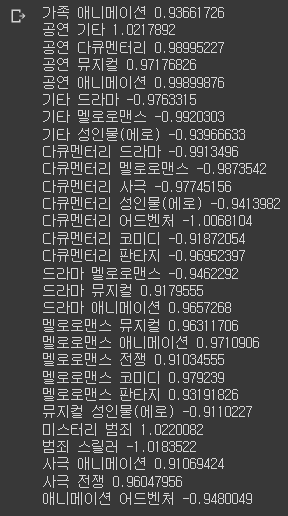

# 결과 해석
* weat 스코어는 예술영화에서 상업영화를 뺀 값으로 설정 ( 함수는 최상단 위치)
* 위는 상관관계가 절대값 90%이상인 값을 가지고 왔음. 더 세부적인 결과를 보려면 절대값 80%이상의 값을 가지고 와야할 것으로 보임
* 양수일수록 예술영화, 음수일수록 상업영화(=일반영화)에 가까운 값이 됨
* 가족, 공연, 드라마, 멜로, 미스터리는 예술영화에 가깝지만, 기타, 다큐멘터리, 범죄 등은 상업(일반)영화와 가까운 것으로 나타났다.

In [ ]:
#코랩 코드깨짐문제 해결을 위해설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumBarunGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(figsize=(13,13))

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

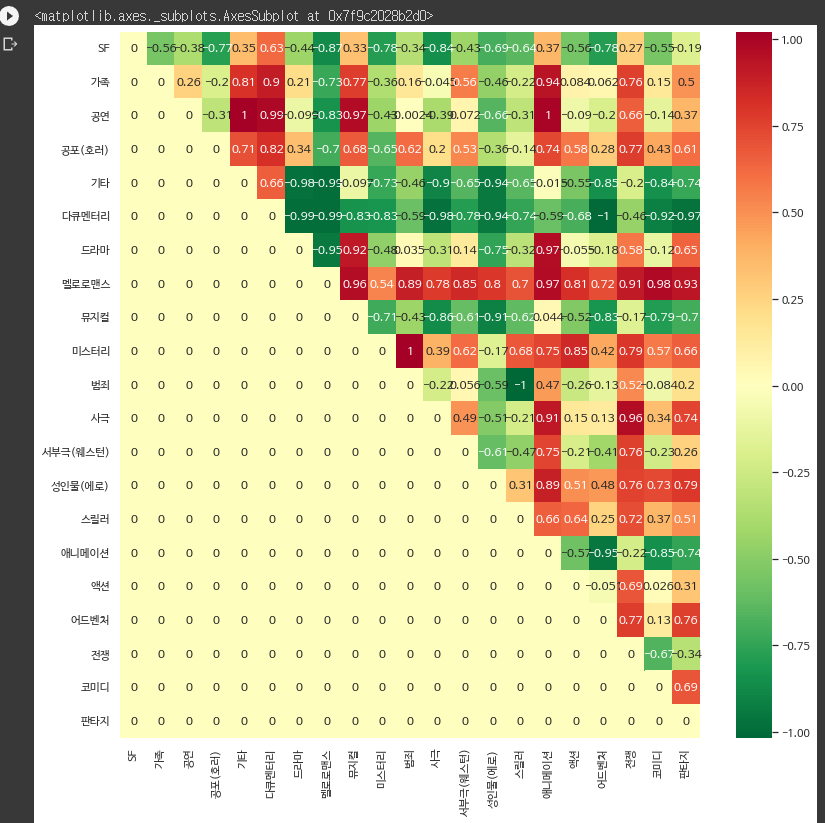

# 회고
* tfidf 행렬을 그대로 사용해도 되는데, 중복을 제거하라고 했을 때 정말 막막했었다. 찾아도 안나오기에 포기하려다가 검색어를 바꾸니 쉽게 쓸 수 있는 함수가 나왔고, 바로 적용시켰다.  
* 오타는 제외인줄 알았는데 포함이었다. 오타를 많이 내서 이런 결과가 나타난 것인데, 이것을 수정하여 넣는 법이 있으면 좋겠지만, 오타를 그대로 유지한다면 조금 더 robust한 결과가 나오지 않을까란 생각이 든다.
* 결과가 의문스러운 점이 있다. 드라마와 미스터리는 일반영화, 다큐멘터리는 예술영화에 가깝다고 생각하는데, 분류는 반대로 되었다. 중복 제거가 잘못되었나...?
* 예술영화, 일반영화의 경계선이 모호해서 예상했던 결과가 나오지 않았을 수도 있을 것 같다. 누가 답지를 펴고 보여줬으면 좋겠다.
* 아니면 target값에만 중복제거를 해준것이 문제일 수도 있을 것 같다. attribute도 삭제하는게 나았을지도 모른다.
* weat score는 처음들어보는 단어라 이해하는데 시간을 많이 사용했다. 빠르게 변화하는 분야인만큼 이해하는 속도가 증가역시 필요해보인다